# Model Selection for scRNA-seq Analysis

This notebook shows how to run all models on a subset of real scRNA-seq data and use AIC to do model selection. We find ZINB achieves the highest log likelihood and the lowest AIC among 7 models.

In [1]:
from models.poi import Poi
from models.nb import NB
from models.poih import PoiH
from models.nbh import NBH
from models.zipoi import ZIPoi
from models.zinb import ZINB
from models.mast import MAST

import numpy as np
import pandas as pd
import time
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tensorzinb.utils import correct_pvalues_for_multiple_testing,normalize_features
from utils import find_independent_columns,gen_feature_df

plt.style.use('ggplot')

## Preparation

In [2]:
model_classes = [Poi, NB, PoiH, NBH, ZIPoi, ZINB, MAST]

methods={
    Poi: ['stan','statsmodels'],
    NB: ['stan','statsmodels','tensorflow'],
    PoiH: ['stan','statsmodels'],
    NBH: ['stan','statsmodels'],
    ZIPoi: ['stan','statsmodels'],
    ZINB: ['stan','statsmodels','tensorflow'],
    MAST: ['statsmodels'],
}

load data

In [3]:
df_g = pd.read_csv('./data/model_sel_genes.csv')
df_m = pd.read_csv('./data/meta.zip',sep='\t')
df_m.set_index('cell', inplace=True)
columns = {"post-mortem interval (hours)": "PMI", "RNA Integrity Number": "RIN", "RNA ribosomal percent": "ribo_pct", "RNA mitochondr. percent": "mito_pct"}
df_feature = df_m.rename(columns=columns)
df =  pd.read_csv('./data/model_sel_count.zip').set_index('cell')


create additional features

In [4]:
df_feature['genes_log'] = np.log(df_feature['genes'])
df_feature['UMIs_log'] = np.log(df_feature['UMIs'])

# for MAST
df_feature['scaler'] = 10000.0/df_feature['UMIs']

In [5]:
exog_features = [
    "UMIs",
    "genes",
    "UMIs_log",
    "genes_log",
    "sex",
    "age",
    "Capbatch",
    "PMI",
    "RIN",
    "ribo_pct",
    "mito_pct",
]

exog_features_infl = [
    "UMIs",
    "UMIs_log",
    "genes_log",
    "sex",
    "age",
    "Capbatch",
    "ribo_pct",
    "mito_pct",
]

features_to_norm = [
    "UMIs",
    "genes",
    "UMIs_log",
    "genes_log",
    "age",
    "PMI",
    "RIN",
    "ribo_pct",
    "mito_pct",
]

In [6]:
clusters = df_g.cluster.unique()

## run all models on sample data

In [7]:
import datetime

suffix = datetime.date.today().strftime("%m_%d_%Y")
pickle_name = "model_selection_{}.pickle".format(suffix)

In [8]:
model_path = "./models"

rs = []
k = 0
for cluster in clusters:
    print(cluster)
    gene_ids = df_g[df_g.cluster == cluster].gene_id.values
    
    # normalize features
    df_feature1 = df_feature[df_feature.cluster == cluster].copy()
    df_feature1 = normalize_features(df_feature1, features_to_norm)

    df_data = pd.merge(
        df[gene_ids], df_feature1.reset_index()[["cell"]], on="cell"
    ).set_index("cell")

    df_exog = gen_feature_df(df_feature1, exog_features)
    df_exog_infl = gen_feature_df(df_feature1, exog_features_infl)

    # find independent features
    cols = find_independent_columns(df_exog)
    exog = df_exog[cols].values
    cols = find_independent_columns(df_exog_infl)
    exog_infl = df_exog_infl[cols].values
    scaler = df_feature1["scaler"].values

    endog = df_data[gene_ids].values

    for model_class in model_classes:
        print(model_class)
        if model_class == MAST:
            mod = model_class(
                endog, exog, exog_infl=exog_infl, model_path="./models", scaler=scaler
            )
        else:
            mod = model_class(endog, exog, exog_infl=exog_infl, model_path="./models")

        for method in methods[model_class]:
            r = mod.fit(method=method)
            for ii in range(len(gene_ids)):
                t = r[ii]
                t["gene_id"] = gene_ids[ii]
                t["cluster"] = cluster
                r[ii] = t
            rs = rs + r

        with open(pickle_name, "wb") as output_file:
            pickle.dump(rs, output_file)

with open(pickle_name, "wb") as output_file:
    pickle.dump(rs, output_file)

In [9]:
dfr=pd.DataFrame(rs)

order=['poi','poih', 'zipoi','mast', 'nb',  'nbh', 'zinb']

## plot log likelihood

we find ZINB attains the highest log likelihood.

In [10]:
df_llf = dfr.groupby(['gene_id', 'cluster','model'])['llf'].max().reset_index()
df_llf['not_nan']=1-np.isnan(df_llf['llf'])
df_llf['cnt']=df_llf.groupby(['gene_id', 'cluster']).transform('sum')['not_nan']
dfp=df_llf[df_llf['cnt']==7].copy()
max_llf = dfp.groupby('model').llf.mean().max()
dfp['llf']=max_llf-dfp['llf']
dfp.groupby('model').llf.mean()

model
mast     2.514231e+02
nb       8.570309e+01
nbh      1.505646e+02
poi      5.690004e+03
poih     5.517142e+03
zinb     1.652159e-12
zipoi    5.418897e+03
Name: llf, dtype: float64

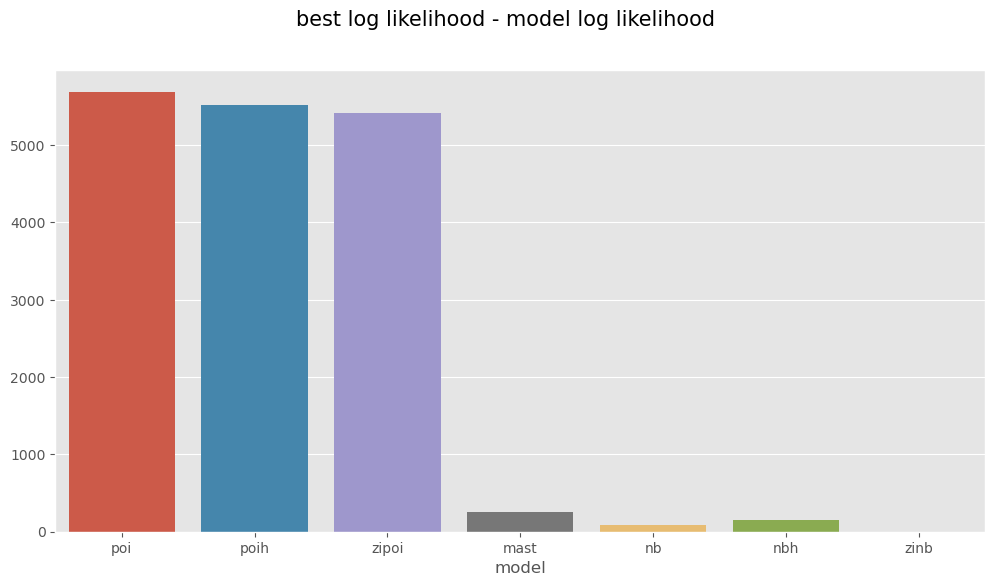

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x="model", y='llf', data=dfp,ax=ax, errorbar=None, order=order)
fig.suptitle('best log likelihood - model log likelihood', fontsize=15);
ax.set_ylabel('');

## plot AIC

we find ZINB attains the lowest AIC.

In [12]:
df_aic = dfr.groupby(['gene_id', 'cluster','model'])['aic'].min().reset_index()
df_aic['not_nan']=1-np.isnan(df_aic['aic'])
df_aic['cnt']=df_aic.groupby(['gene_id', 'cluster']).transform('sum')['not_nan']
dfp=df_aic[df_aic['cnt']==7].copy()
min_aic = dfp.groupby('model').aic.mean().min()
dfp['aic']=dfp['aic']-min_aic
dfp.groupby('model').aic.mean()

model
mast     5.007574e+02
nb       1.414062e+02
nbh      3.011291e+02
poi      1.134801e+04
poih     1.103228e+04
zinb     3.304318e-12
zipoi    1.083579e+04
Name: aic, dtype: float64

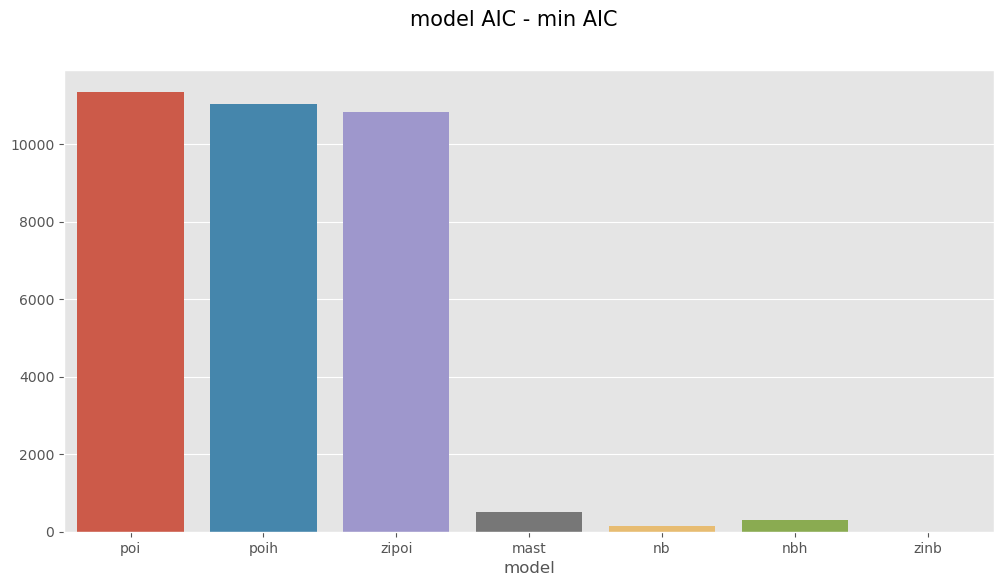

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x="model", y='aic', data=dfp,ax=ax, errorbar=None, order=order)
fig.suptitle('model AIC - min AIC', fontsize=15);
ax.set_ylabel('');

## plot computing time

In [14]:
df_time= dfr.groupby(['gene_id', 'cluster','model'])['cpu_time'].min().reset_index()
df_time['not_nan']=1-np.isnan(df_time['cpu_time'])
df_time['cnt']=df_time.groupby(['gene_id', 'cluster']).transform('sum')['not_nan']
dfp=df_time[df_time['cnt']==7].copy()
min_time = dfp.groupby('model').cpu_time.mean().min()
dfp['cpu_time']=dfp['cpu_time']
dfp.groupby('model').cpu_time.mean()

model
mast      0.244022
nb        0.367950
nbh      13.528446
poi       0.022161
poih      0.670150
zinb      0.817458
zipoi     4.141872
Name: cpu_time, dtype: float64

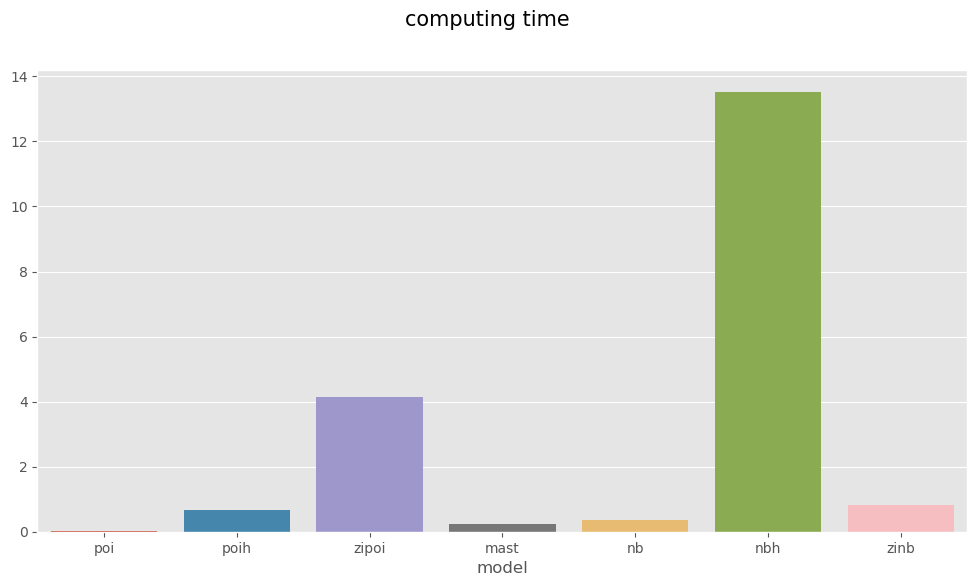

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x="model", y='cpu_time', data=dfp,ax=ax, errorbar=None, order=order)
fig.suptitle('computing time', fontsize=15);
ax.set_ylabel('');

## ZINB method compare

TensorZINB achieves the highest log likelihood with the lowest computing time.

In [16]:
df_zinb=dfr[dfr.model=='zinb'].copy()
df_zinb['not_nan']=1-np.isnan(df_zinb['llf'])
df_zinb['cnt']=df_zinb.groupby(['gene_id', 'cluster'])['not_nan'].transform('sum')
df_zinb[df_zinb['cnt']==3].groupby(['method'])['llf'].mean()

method
stan          -12824.727643
statsmodels   -13434.019255
tensorflow    -12764.196961
Name: llf, dtype: float64

In [17]:
df_zinb[df_zinb['cnt']==3].groupby(['method'])['cpu_time'].mean()

method
stan            5.234233
statsmodels    21.187485
tensorflow      0.821549
Name: cpu_time, dtype: float64

statsmodels fails to return results for most genes.